Link do notatnika: https://colab.research.google.com/drive/1Z-egQCfFVTTE1RT78R4LCyXaPC2iimtI?usp=sharing

---


# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, odbicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

100%|██████████| 170498071/170498071 [00:03<00:00, 47623612.77it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root


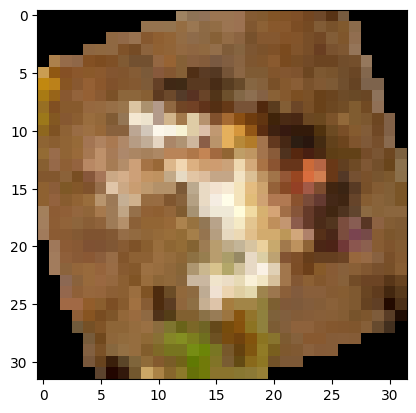

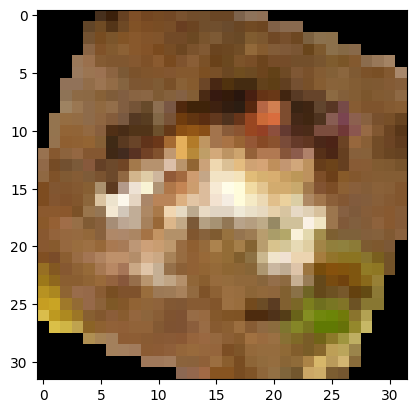

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt


transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()



True

In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

test_ds, val_ds = train_test_split(test_ds, test_size=0.5) # był błąd

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=32, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch).sum()
        correct += count_correct(y_pred, y_batch)
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_loader: DataLoader,
    dev_loader: DataLoader, epochs: int, patience: int,
    print_metrics: str = True
):
    loss_train_log=[]
    acc_train_log=[]
    loss_dev_log=[]
    acc_dev_log=[]

    best_loss = np.inf
    num_patience = 1

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_loader)
                dev_loss, dev_acc = validate(model, loss_fn, dev_loader)
                print(
                    f"Epoch {epoch+1}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {dev_loss:.3f} (acc: {dev_acc:.3f})"
                )
                loss_train_log.append(round(float(train_loss.cpu()),4))
                acc_train_log.append(round(float(train_acc.cpu()),4))
                loss_dev_log.append(round(float(dev_loss.cpu()),4))
                acc_dev_log.append(round(float(dev_acc.cpu()),4))

        if  dev_loss < best_loss:
            print(f'Zapisujemy model z acc={dev_acc}, loss={dev_loss}, po epoce:{epoch+1}\n')
            best_loss = dev_loss
            num_patience = 0
            torch.save(
                obj={
                    'epoch': epoch,
                    'loss': dev_loss,
                    'acc': dev_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict()
                    }, f='/content/drive/MyDrive/lab06/model_checkopint.pth'
                    )
        else:
            num_patience += 1
            print(f'Model nie poprawił się od: {num_patience} epok.\n')

        if num_patience >= patience:
            print(f'Koniec uczenia')
            break

    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    epoch_list = np.arange(1, epochs+1)
    return epoch_list, loss_train_log, acc_train_log, loss_dev_log, acc_dev_log

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def test_model(test_loader, model):
  y_pred = []
  y_true = []
  with torch.no_grad():
    for (data, labels) in test_loader:
      data, labels = data.to(device), labels.to(device)
      net_out = model(data)
      for row in net_out:
        y_pred.append(int(torch.argmax(row.cpu()))) # Save Prediction
      for row in labels:
        y_true.append(int(row.data.cpu())) # Save Truth
  return y_pred, y_true

# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [ ]:
class ThreeLayerCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1",
                          torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2",
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
    self.model.add_module("conv3",
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(8*8*channels, 10))

  def forward(self, x):
    return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

In [ ]:
import os
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
layer3_model = ThreeLayerCNN(channels=32, labels=10)
layer3_model.to(device)

ThreeLayerCNN(
  (model): Sequential(
    (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1): ReLU()
    (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_2): ReLU()
    (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear): Linear(in_features=2048, out_features=10, bias=True)
  )
)

In [ ]:
 # zaprojektuj eksperyment sprawdzający kilka możliwych podejść do augmentacji, wybranych z dokumentacji torchvision.transforms
transform_1 = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

train_ds_1 = torchvision.datasets.CIFAR10("cifar_root", transform=transform_1, download=True)
train_dl_1 = DataLoader(train_ds_1, batch_size=32, shuffle=True, pin_memory=True)

transform_2 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

train_ds_2 = torchvision.datasets.CIFAR10("cifar_root", transform=transform_2, download=True)
train_dl_2 = DataLoader(train_ds_2, batch_size=32, shuffle=True, pin_memory=True)

transform_3 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=3,sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

train_ds_3 = torchvision.datasets.CIFAR10("cifar_root", transform=transform_3, download=True)
train_dl_3 = DataLoader(train_ds_3, batch_size=32, shuffle=True, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


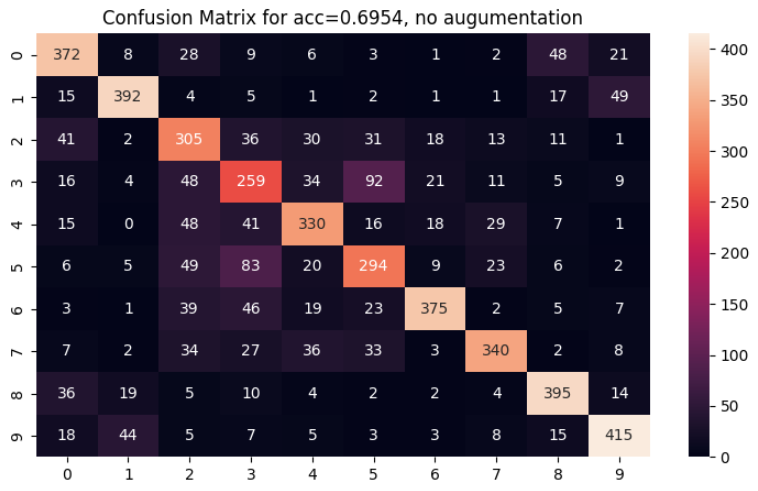

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns

## Rotacja 30

In [ ]:
optimiser = optim.Adam(layer3_model.parameters())

loss_fn = torch.nn.CrossEntropyLoss()  # Funkcja straty: Entropia krzyżowa

epochs_1, loss_train_log_1, acc_train_log_1, loss_dev_log_1, acc_dev_log_1 = fit(
    model=layer3_model, optimiser=optimiser, loss_fn=loss_fn,
    train_loader=train_dl_1, dev_loader=val_dl, epochs=50,
    patience=12
)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.043 (acc: 0.514), validation loss = 0.042 (acc: 0.532)
Zapisujemy model z acc=0.5321999788284302, loss=0.04162865877151489, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.038 (acc: 0.567), validation loss = 0.037 (acc: 0.585)
Zapisujemy model z acc=0.5845999717712402, loss=0.03693177551031113, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.036 (acc: 0.592), validation loss = 0.034 (acc: 0.616)
Zapisujemy model z acc=0.6164000034332275, loss=0.034256476908922195, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.035 (acc: 0.601), validation loss = 0.034 (acc: 0.620)
Zapisujemy model z acc=0.6195999979972839, loss=0.03374183177947998, po epoce:4



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.035 (acc: 0.610), validation loss = 0.033 (acc: 0.636)
Zapisujemy model z acc=0.6359999775886536, loss=0.03262842446565628, po epoce:5



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.033 (acc: 0.627), validation loss = 0.031 (acc: 0.655)
Zapisujemy model z acc=0.6553999781608582, loss=0.03148452937602997, po epoce:6



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.034 (acc: 0.616), validation loss = 0.031 (acc: 0.650)
Zapisujemy model z acc=0.6503999829292297, loss=0.03100561536848545, po epoce:7



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.034 (acc: 0.628), validation loss = 0.031 (acc: 0.663)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.031 (acc: 0.646), validation loss = 0.029 (acc: 0.669)
Zapisujemy model z acc=0.668999969959259, loss=0.029333364218473434, po epoce:9



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.033 (acc: 0.631), validation loss = 0.032 (acc: 0.652)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.032 (acc: 0.644), validation loss = 0.031 (acc: 0.663)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.032 (acc: 0.636), validation loss = 0.030 (acc: 0.658)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.031 (acc: 0.643), validation loss = 0.030 (acc: 0.675)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.031 (acc: 0.655), validation loss = 0.029 (acc: 0.673)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss = 0.031 (acc: 0.657), validation loss = 0.030 (acc: 0.671)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: train loss = 0.031 (acc: 0.645), validation loss = 0.030 (acc: 0.665)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: train loss = 0.030 (acc: 0.662), validation loss = 0.029 (acc: 0.687)
Zapisujemy model z acc=0.6873999834060669, loss=0.0290918480604887, po epoce:17



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18: train loss = 0.031 (acc: 0.655), validation loss = 0.029 (acc: 0.682)
Zapisujemy model z acc=0.6823999881744385, loss=0.028901591897010803, po epoce:18



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19: train loss = 0.030 (acc: 0.664), validation loss = 0.029 (acc: 0.689)
Zapisujemy model z acc=0.6887999773025513, loss=0.028645388782024384, po epoce:19



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20: train loss = 0.030 (acc: 0.661), validation loss = 0.029 (acc: 0.676)
Zapisujemy model z acc=0.6759999990463257, loss=0.028541777282953262, po epoce:20



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 21: train loss = 0.030 (acc: 0.665), validation loss = 0.029 (acc: 0.680)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 22: train loss = 0.030 (acc: 0.661), validation loss = 0.029 (acc: 0.681)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 23: train loss = 0.029 (acc: 0.669), validation loss = 0.028 (acc: 0.685)
Zapisujemy model z acc=0.6847999691963196, loss=0.028216835111379623, po epoce:23



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 24: train loss = 0.029 (acc: 0.675), validation loss = 0.028 (acc: 0.687)
Zapisujemy model z acc=0.6873999834060669, loss=0.028115348890423775, po epoce:24



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 25: train loss = 0.029 (acc: 0.666), validation loss = 0.028 (acc: 0.689)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 26: train loss = 0.029 (acc: 0.678), validation loss = 0.028 (acc: 0.694)
Zapisujemy model z acc=0.6940000057220459, loss=0.027691802009940147, po epoce:26



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 27: train loss = 0.029 (acc: 0.670), validation loss = 0.028 (acc: 0.692)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 28: train loss = 0.029 (acc: 0.671), validation loss = 0.028 (acc: 0.696)
Zapisujemy model z acc=0.6961999535560608, loss=0.027544554322957993, po epoce:28



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 29: train loss = 0.028 (acc: 0.684), validation loss = 0.028 (acc: 0.698)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 30: train loss = 0.029 (acc: 0.677), validation loss = 0.029 (acc: 0.682)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 31: train loss = 0.028 (acc: 0.682), validation loss = 0.028 (acc: 0.694)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 32: train loss = 0.028 (acc: 0.681), validation loss = 0.027 (acc: 0.702)
Zapisujemy model z acc=0.7015999555587769, loss=0.026766985654830933, po epoce:32



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 33: train loss = 0.028 (acc: 0.689), validation loss = 0.027 (acc: 0.701)
Zapisujemy model z acc=0.7013999819755554, loss=0.026729002594947815, po epoce:33



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 34: train loss = 0.029 (acc: 0.672), validation loss = 0.029 (acc: 0.688)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 35: train loss = 0.028 (acc: 0.682), validation loss = 0.027 (acc: 0.699)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 36: train loss = 0.028 (acc: 0.687), validation loss = 0.027 (acc: 0.704)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 37: train loss = 0.029 (acc: 0.669), validation loss = 0.029 (acc: 0.689)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 38: train loss = 0.029 (acc: 0.671), validation loss = 0.028 (acc: 0.689)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 39: train loss = 0.028 (acc: 0.682), validation loss = 0.027 (acc: 0.692)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 40: train loss = 0.028 (acc: 0.683), validation loss = 0.028 (acc: 0.697)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 41: train loss = 0.029 (acc: 0.677), validation loss = 0.027 (acc: 0.701)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 42: train loss = 0.028 (acc: 0.680), validation loss = 0.028 (acc: 0.688)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 43: train loss = 0.028 (acc: 0.685), validation loss = 0.027 (acc: 0.696)
Model nie poprawił się od: 10 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 44: train loss = 0.028 (acc: 0.683), validation loss = 0.028 (acc: 0.704)
Model nie poprawił się od: 11 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 45: train loss = 0.027 (acc: 0.694), validation loss = 0.027 (acc: 0.709)
Zapisujemy model z acc=0.7087999582290649, loss=0.0265404861420393, po epoce:45



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 46: train loss = 0.028 (acc: 0.690), validation loss = 0.027 (acc: 0.703)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 47: train loss = 0.027 (acc: 0.691), validation loss = 0.027 (acc: 0.705)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 48: train loss = 0.028 (acc: 0.682), validation loss = 0.028 (acc: 0.702)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 49: train loss = 0.029 (acc: 0.680), validation loss = 0.028 (acc: 0.695)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 50: train loss = 0.027 (acc: 0.689), validation loss = 0.026 (acc: 0.707)
Zapisujemy model z acc=0.70660001039505, loss=0.02645711973309517, po epoce:50



In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab06/model_checkopint.pth')

model_state_dict = checkpoint['model_state_dict']
layer3_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.6996, precision=0.6996, f1=0.6996.


<Axes: title={'center': 'Confusion Matrix for acc=0.6996, Random Rotation'}>

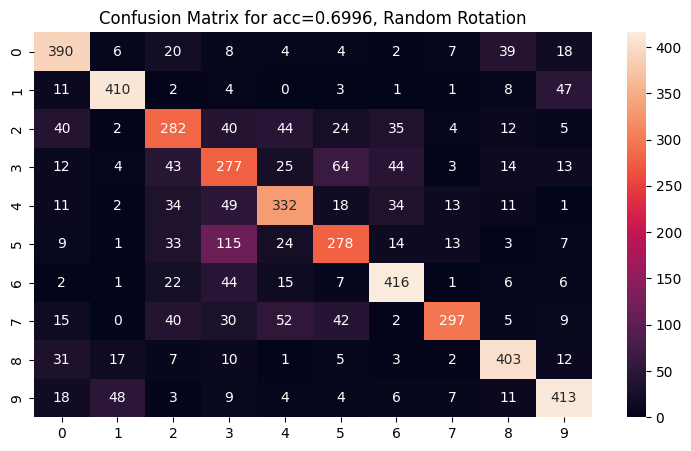

In [ ]:
y_pred, y_true = test_model(test_dl, layer3_model)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
f1_score = f1_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}, f1={f1_score}.')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}, Random Rotation')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

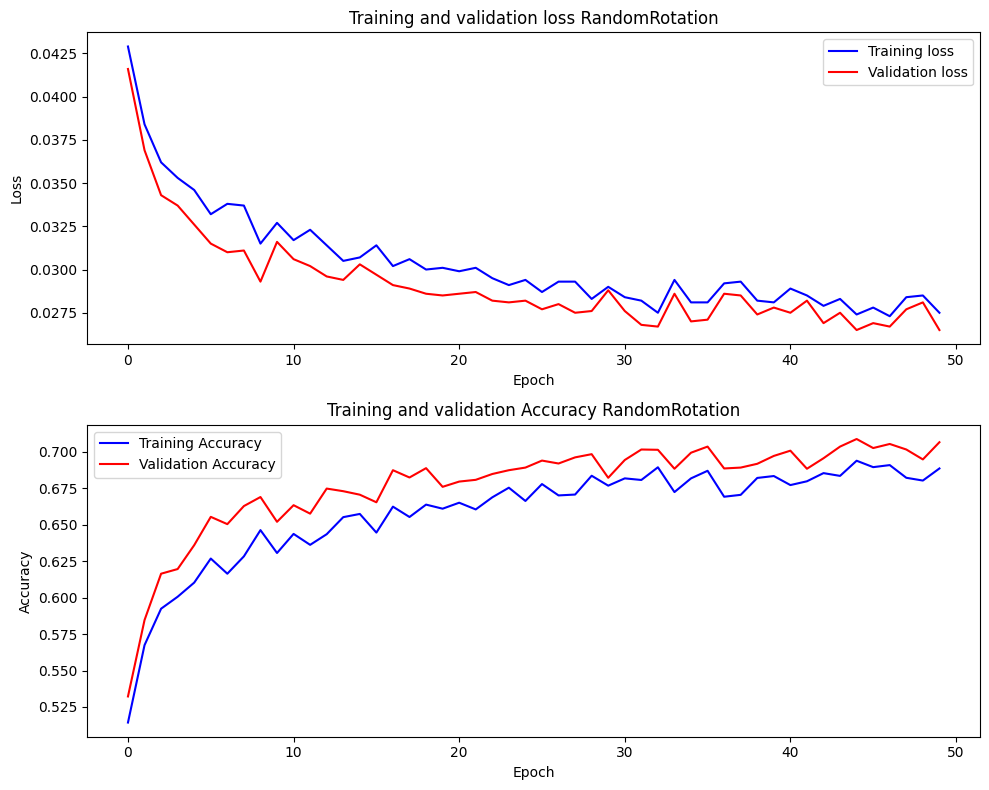

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_1)), loss_train_log_1, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_1)), loss_dev_log_1, 'r', label='Validation loss')
ax1.set_title('Training and validation loss RandomRotation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_1)), acc_train_log_1, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_1)), acc_dev_log_1, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy RandomRotation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

## RandomHorizontalFlip

In [ ]:
layer3_model = ThreeLayerCNN(channels=32, labels=10)
layer3_model.to(device)

optimiser = optim.Adam(layer3_model.parameters())

loss_fn = torch.nn.CrossEntropyLoss()  # Funkcja straty: Entropia krzyżowa

epochs_2, loss_train_log_2, acc_train_log_2, loss_dev_log_2, acc_dev_log_2 = fit(
    model=layer3_model, optimiser=optimiser, loss_fn=loss_fn,
    train_loader=train_dl_2, dev_loader=val_dl, epochs=50,
    patience=12
)

In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab06/model_checkopint.pth')

model_state_dict = checkpoint['model_state_dict']
layer3_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.7272, precision=0.7272


<Axes: title={'center': 'Confusion Matrix for acc=0.7272, HorizontalFlip'}>

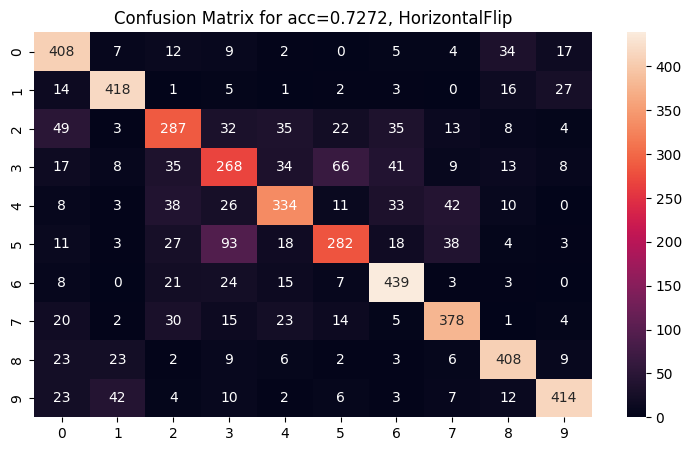

In [ ]:
y_pred, y_true = test_model(test_dl, layer3_model)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}, HorizontalFlip')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

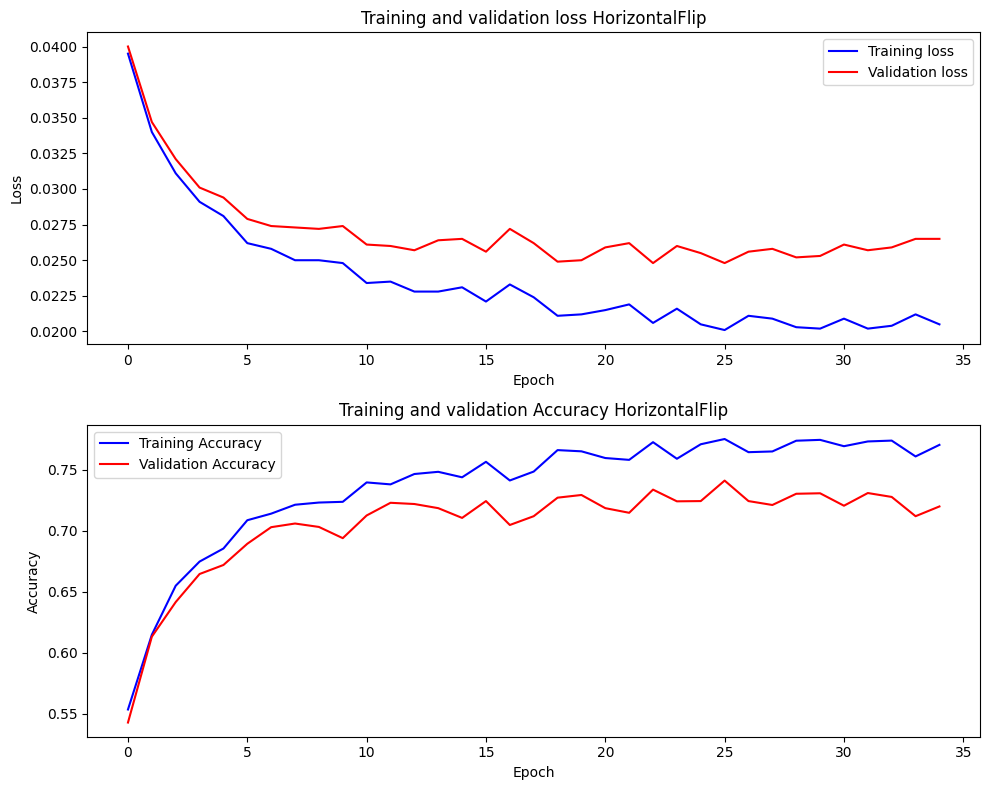

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_2)), loss_train_log_2, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_2)), loss_dev_log_2, 'r', label='Validation loss')
ax1.set_title('Training and validation loss HorizontalFlip')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_2)), acc_train_log_2, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_2)), acc_dev_log_2, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy HorizontalFlip')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

## Gaussianblur

In [ ]:
layer3_model = ThreeLayerCNN(channels=32, labels=10)
layer3_model.to(device)

optimiser = optim.Adam(layer3_model.parameters())

loss_fn = torch.nn.CrossEntropyLoss()  # Funkcja straty: Entropia krzyżowa

epochs_3, loss_train_log_3, acc_train_log_3, loss_dev_log_3, acc_dev_log_3 = fit(
    model=layer3_model, optimiser=optimiser, loss_fn=loss_fn,
    train_loader=train_dl_3, dev_loader=val_dl, epochs=50,
    patience=6
)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.041 (acc: 0.535), validation loss = 0.041 (acc: 0.528)
Zapisujemy model z acc=0.527999997138977, loss=0.04105228930711746, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.036 (acc: 0.588), validation loss = 0.038 (acc: 0.580)
Zapisujemy model z acc=0.5801999568939209, loss=0.03750414401292801, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.034 (acc: 0.611), validation loss = 0.037 (acc: 0.592)
Zapisujemy model z acc=0.5916000008583069, loss=0.03653625398874283, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.034 (acc: 0.618), validation loss = 0.037 (acc: 0.598)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.032 (acc: 0.643), validation loss = 0.035 (acc: 0.613)
Zapisujemy model z acc=0.6125999689102173, loss=0.03476428613066673, po epoce:5



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.031 (acc: 0.658), validation loss = 0.033 (acc: 0.641)
Zapisujemy model z acc=0.6407999992370605, loss=0.03274433687329292, po epoce:6



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.029 (acc: 0.673), validation loss = 0.033 (acc: 0.639)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.029 (acc: 0.681), validation loss = 0.032 (acc: 0.650)
Zapisujemy model z acc=0.6499999761581421, loss=0.0322897769510746, po epoce:8



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.028 (acc: 0.688), validation loss = 0.032 (acc: 0.648)
Zapisujemy model z acc=0.6480000019073486, loss=0.03214525803923607, po epoce:9



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.027 (acc: 0.697), validation loss = 0.032 (acc: 0.656)
Zapisujemy model z acc=0.6557999849319458, loss=0.03204484283924103, po epoce:10



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.027 (acc: 0.705), validation loss = 0.032 (acc: 0.655)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.026 (acc: 0.707), validation loss = 0.032 (acc: 0.658)
Zapisujemy model z acc=0.6579999923706055, loss=0.031728893518447876, po epoce:12



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.026 (acc: 0.710), validation loss = 0.032 (acc: 0.654)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.026 (acc: 0.711), validation loss = 0.032 (acc: 0.652)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss = 0.026 (acc: 0.707), validation loss = 0.034 (acc: 0.643)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: train loss = 0.024 (acc: 0.731), validation loss = 0.031 (acc: 0.669)
Zapisujemy model z acc=0.6693999767303467, loss=0.031224168837070465, po epoce:16



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: train loss = 0.024 (acc: 0.726), validation loss = 0.032 (acc: 0.663)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18: train loss = 0.026 (acc: 0.711), validation loss = 0.034 (acc: 0.645)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19: train loss = 0.024 (acc: 0.728), validation loss = 0.033 (acc: 0.658)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20: train loss = 0.023 (acc: 0.740), validation loss = 0.032 (acc: 0.673)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 21: train loss = 0.023 (acc: 0.742), validation loss = 0.032 (acc: 0.667)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 22: train loss = 0.024 (acc: 0.737), validation loss = 0.033 (acc: 0.663)
Model nie poprawił się od: 6 epok.

Koniec uczenia


In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab06/model_checkopint.pth')

model_state_dict = checkpoint['model_state_dict']
layer3_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.6686, precision=0.6686


<Axes: title={'center': 'Confusion Matrix for acc=0.6686, GaussianBlur'}>

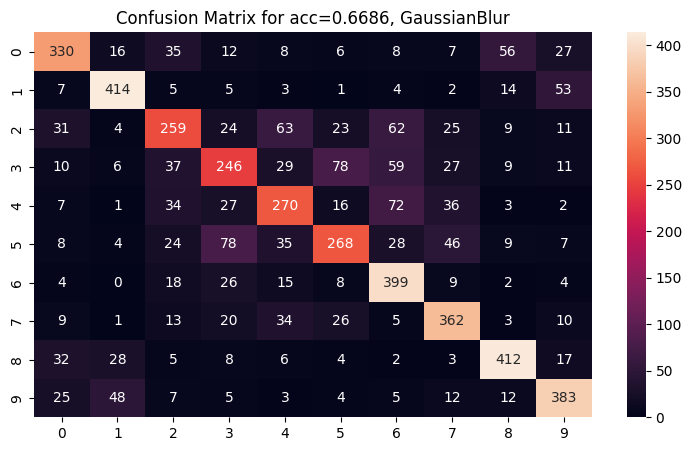

In [ ]:
y_pred, y_true = test_model(test_dl, layer3_model)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}, GaussianBlur')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

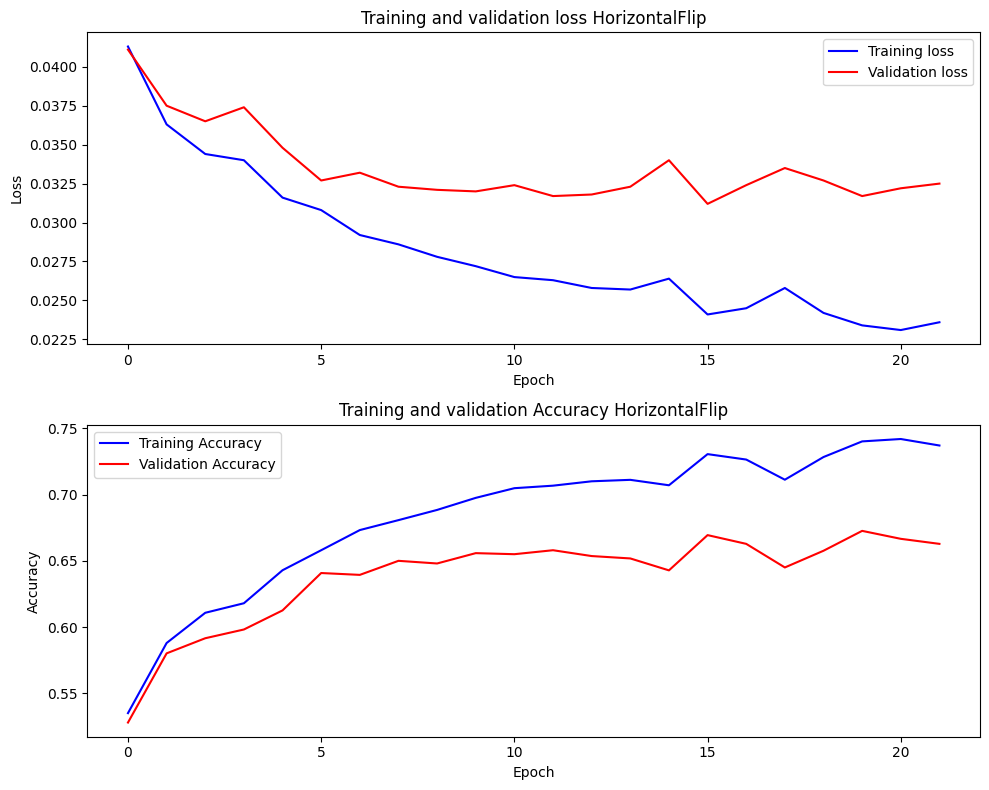

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_3)), loss_train_log_3, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_3)), loss_dev_log_3, 'r', label='Validation loss')
ax1.set_title('Training and validation loss HorizontalFlip')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_3)), acc_train_log_3, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_3)), acc_dev_log_3, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy HorizontalFlip')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [ ]:
def fit_mix(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_loader: DataLoader,
    dev_loader: DataLoader, epochs: int, patience: int, alpha: float=1,
    beta:float=1, print_metrics: str = True
):
    loss_train_log=[]
    acc_train_log=[]
    loss_dev_log=[]
    acc_dev_log=[]

    best_loss = np.inf
    num_patience = 1

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            lambda_ = np.random.beta(alpha, beta)
            # zmodyfikuj implementację pętli uczącej
            batch_size = X_batch.size()[0] #ilośc przykładów
            index = torch.randperm(batch_size) #losowy index
            mixed_x = lambda_ * X_batch + (1 - lambda_) * X_batch[index, :] #policzenie mixup dla obecnego i randomowego
            y_a, y_b = y_batch, y_batch[index]  # y dla obecnego i randomowego
            X_batch, y_batch_1, y_batch_2 = mixed_x.cuda(), y_a.cuda(), y_b.cuda()

            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            y_batch_1 = y_batch_1.type(torch.LongTensor).cuda()
            y_batch_2 = y_batch_2.type(torch.LongTensor).cuda()
            # loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty
            loss = lambda_ * loss_fn(y_pred, y_batch_1) + (1 - lambda_) * loss_fn(y_pred, y_batch_2)

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_loader)
                dev_loss, dev_acc = validate(model, loss_fn, dev_loader)
                print(
                    f"Epoch {epoch+1}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {dev_loss:.3f} (acc: {dev_acc:.3f})"
                )
                loss_train_log.append(round(float(train_loss.cpu()),4))
                acc_train_log.append(round(float(train_acc.cpu()),4))
                loss_dev_log.append(round(float(dev_loss.cpu()),4))
                acc_dev_log.append(round(float(dev_acc.cpu()),4))

        if  dev_loss < best_loss:
            print(f'Zapisujemy model z acc={dev_acc}, loss={dev_loss}, po epoce:{epoch+1}\n')
            best_loss = dev_loss
            num_patience = 0
            torch.save(
                obj={
                    'epoch': epoch,
                    'loss': dev_loss,
                    'acc': dev_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict()
                    }, f='/content/drive/MyDrive/lab06/model_checkopint.pth'
                    )
        else:
            num_patience += 1
            print(f'Model nie poprawił się od: {num_patience} epok.\n')

        if num_patience >= patience:
            print(f'Koniec uczenia')
            break

    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    epoch_list = np.arange(1, epochs+1)
    return epoch_list, loss_train_log, acc_train_log, loss_dev_log, acc_dev_log

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji.



In [ ]:
# przetestuj wyniki z wykorzystaniem zmodyfikowanego fit()
layer3_model = ThreeLayerCNN(channels=32, labels=10)
layer3_model.to(device)

optimiser = optim.Adam(layer3_model.parameters())

loss_fn = torch.nn.CrossEntropyLoss()  # Funkcja straty: Entropia krzyżowa

epochs_mix, loss_train_log_mix, acc_train_log_mix, loss_dev_log_mix, acc_dev_log_mix = fit_mix(
    model=layer3_model, optimiser=optimiser, loss_fn=loss_fn,
    train_loader=train_dl, dev_loader=val_dl, epochs=50, alpha=0.5, beta=0.5,
    patience=12
)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.041 (acc: 0.548), validation loss = 0.042 (acc: 0.534)
Zapisujemy model z acc=0.5339999794960022, loss=0.041749268770217896, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.036 (acc: 0.612), validation loss = 0.037 (acc: 0.594)
Zapisujemy model z acc=0.5938000082969666, loss=0.03699285909533501, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.033 (acc: 0.643), validation loss = 0.035 (acc: 0.621)
Zapisujemy model z acc=0.6207999587059021, loss=0.0345962718129158, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.031 (acc: 0.674), validation loss = 0.033 (acc: 0.642)
Zapisujemy model z acc=0.6417999863624573, loss=0.03281741216778755, po epoce:4



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.030 (acc: 0.675), validation loss = 0.033 (acc: 0.637)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.029 (acc: 0.703), validation loss = 0.031 (acc: 0.663)
Zapisujemy model z acc=0.6631999611854553, loss=0.0311856921762228, po epoce:6



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.028 (acc: 0.706), validation loss = 0.031 (acc: 0.663)
Zapisujemy model z acc=0.6633999943733215, loss=0.030976705253124237, po epoce:7



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.027 (acc: 0.722), validation loss = 0.030 (acc: 0.670)
Zapisujemy model z acc=0.6703999638557434, loss=0.030454836785793304, po epoce:8



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.026 (acc: 0.729), validation loss = 0.030 (acc: 0.681)
Zapisujemy model z acc=0.6805999875068665, loss=0.029682543128728867, po epoce:9



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.025 (acc: 0.737), validation loss = 0.029 (acc: 0.679)
Zapisujemy model z acc=0.6787999868392944, loss=0.029450654983520508, po epoce:10



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.025 (acc: 0.748), validation loss = 0.029 (acc: 0.686)
Zapisujemy model z acc=0.686199963092804, loss=0.029144084081053734, po epoce:11



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.024 (acc: 0.745), validation loss = 0.029 (acc: 0.681)
Zapisujemy model z acc=0.6809999942779541, loss=0.028841640800237656, po epoce:12



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.025 (acc: 0.742), validation loss = 0.030 (acc: 0.679)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.025 (acc: 0.739), validation loss = 0.031 (acc: 0.666)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss = 0.024 (acc: 0.748), validation loss = 0.029 (acc: 0.677)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: train loss = 0.024 (acc: 0.755), validation loss = 0.029 (acc: 0.682)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: train loss = 0.024 (acc: 0.756), validation loss = 0.030 (acc: 0.683)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18: train loss = 0.023 (acc: 0.768), validation loss = 0.029 (acc: 0.695)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 19: train loss = 0.023 (acc: 0.770), validation loss = 0.029 (acc: 0.698)
Zapisujemy model z acc=0.698199987411499, loss=0.028547227382659912, po epoce:19



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 20: train loss = 0.023 (acc: 0.761), validation loss = 0.029 (acc: 0.682)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 21: train loss = 0.022 (acc: 0.777), validation loss = 0.029 (acc: 0.697)
Zapisujemy model z acc=0.6965999603271484, loss=0.028515905141830444, po epoce:21



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 22: train loss = 0.022 (acc: 0.780), validation loss = 0.028 (acc: 0.701)
Zapisujemy model z acc=0.7009999752044678, loss=0.028186149895191193, po epoce:22



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 23: train loss = 0.023 (acc: 0.763), validation loss = 0.029 (acc: 0.692)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 24: train loss = 0.023 (acc: 0.765), validation loss = 0.029 (acc: 0.686)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 25: train loss = 0.022 (acc: 0.785), validation loss = 0.028 (acc: 0.704)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 26: train loss = 0.022 (acc: 0.789), validation loss = 0.028 (acc: 0.703)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 27: train loss = 0.022 (acc: 0.779), validation loss = 0.029 (acc: 0.693)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 28: train loss = 0.020 (acc: 0.795), validation loss = 0.027 (acc: 0.707)
Zapisujemy model z acc=0.7067999839782715, loss=0.02748245745897293, po epoce:28



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 29: train loss = 0.021 (acc: 0.790), validation loss = 0.027 (acc: 0.712)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 30: train loss = 0.023 (acc: 0.764), validation loss = 0.030 (acc: 0.677)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 31: train loss = 0.021 (acc: 0.776), validation loss = 0.029 (acc: 0.686)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 32: train loss = 0.023 (acc: 0.769), validation loss = 0.030 (acc: 0.673)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 33: train loss = 0.021 (acc: 0.790), validation loss = 0.029 (acc: 0.691)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 34: train loss = 0.021 (acc: 0.786), validation loss = 0.029 (acc: 0.695)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 35: train loss = 0.021 (acc: 0.793), validation loss = 0.029 (acc: 0.693)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 36: train loss = 0.021 (acc: 0.791), validation loss = 0.028 (acc: 0.698)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 37: train loss = 0.020 (acc: 0.803), validation loss = 0.028 (acc: 0.713)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 38: train loss = 0.021 (acc: 0.800), validation loss = 0.029 (acc: 0.698)
Model nie poprawił się od: 10 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 39: train loss = 0.021 (acc: 0.793), validation loss = 0.029 (acc: 0.693)
Model nie poprawił się od: 11 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 40: train loss = 0.020 (acc: 0.798), validation loss = 0.028 (acc: 0.698)
Model nie poprawił się od: 12 epok.

Koniec uczenia


In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab06/model_checkopint.pth')

model_state_dict = checkpoint['model_state_dict']
layer3_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.7082, precision=0.7082


<Axes: title={'center': 'Confusion Matrix for acc=0.7082, MixUp'}>

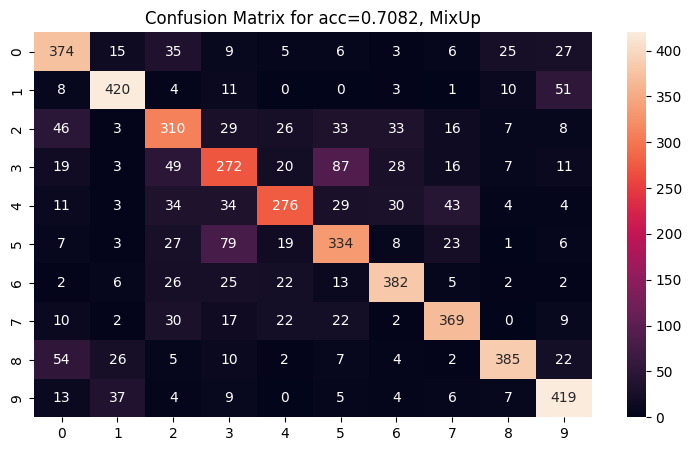

In [ ]:
y_pred, y_true = test_model(test_dl, layer3_model)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}, MixUp')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

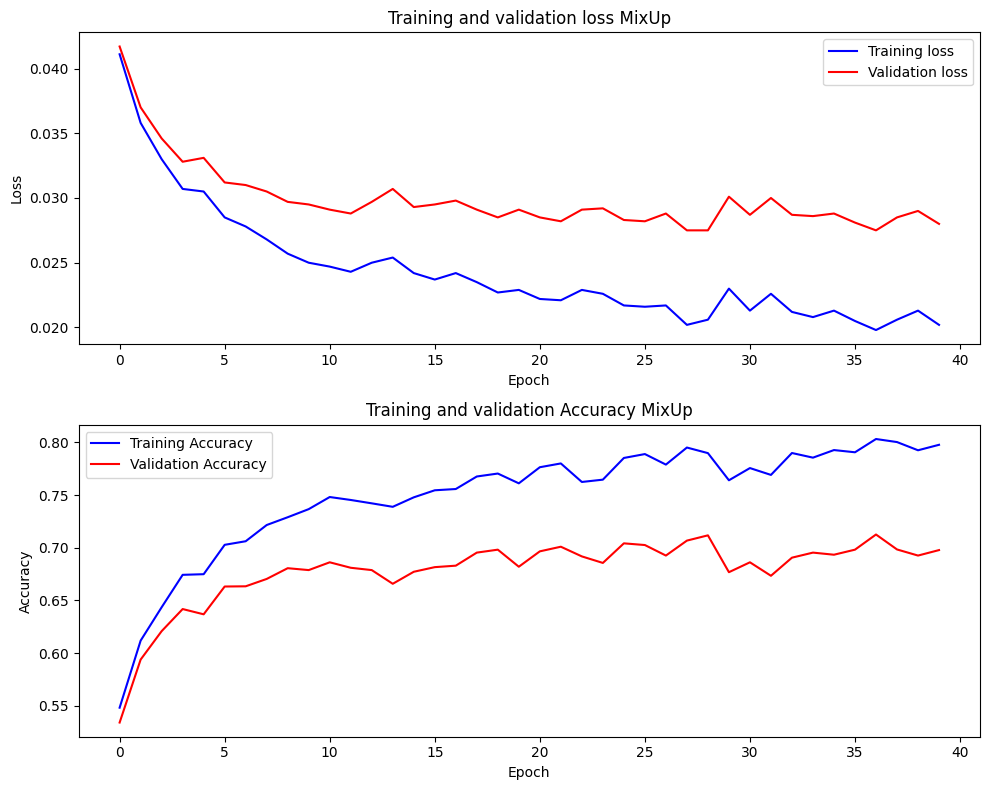

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_mix)), loss_train_log_mix, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_mix)), loss_dev_log_mix, 'r', label='Validation loss')
ax1.set_title('Training and validation loss MixUp')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_mix)), acc_train_log_mix, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_mix)), acc_dev_log_mix, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy MixUp')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.



In [ ]:
class SkipBlock(torch.nn.Module):
  def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.conv_skip = torch.nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)

  def forward(self, x):
        x_skip = self.conv_skip(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        return x + x_skip



class SkipBlockCNN(torch.nn.Module):
  def __init__(self, channels: list[int], labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("res_1", SkipBlock(3, channels[0]))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
    self.model.add_module("relu_3", torch.nn.ReLU())
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(4*4*channels[2], labels))

  def forward(self, x):
    return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [ ]:
model_skip = SkipBlockCNN([16,32,64], labels=10)
model_skip.to(device)
# wyucz sieć i porównaj wyniki

SkipBlockCNN(
  (model): Sequential(
    (res_1): SkipBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv_skip): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    )
    (relu_1): ReLU()
    (res_2): SkipBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv_skip): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (relu_2): ReLU()
    (res_3): SkipBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (conv_skip): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    )
    (relu_3): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (

In [ ]:
optimiser = optim.Adam(model_skip.parameters())

loss_fn = torch.nn.CrossEntropyLoss()  # Funkcja straty: Entropia krzyżowa

epochs_1, loss_train_log_1, acc_train_log_1, loss_dev_log_1, acc_dev_log_1 = fit(
    model=model_skip, optimiser=optimiser, loss_fn=loss_fn,
    train_loader=train_dl, dev_loader=val_dl, epochs=50,
    patience=12
)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.044 (acc: 0.510), validation loss = 0.045 (acc: 0.502)
Zapisujemy model z acc=0.5023999810218811, loss=0.044638387858867645, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.031 (acc: 0.647), validation loss = 0.034 (acc: 0.614)
Zapisujemy model z acc=0.6137999892234802, loss=0.033656537532806396, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.028 (acc: 0.690), validation loss = 0.031 (acc: 0.640)
Zapisujemy model z acc=0.6398000121116638, loss=0.03131529688835144, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.024 (acc: 0.737), validation loss = 0.029 (acc: 0.676)
Zapisujemy model z acc=0.675599992275238, loss=0.028695300221443176, po epoce:4



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.021 (acc: 0.762), validation loss = 0.028 (acc: 0.687)
Zapisujemy model z acc=0.6869999766349792, loss=0.02793797291815281, po epoce:5



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.020 (acc: 0.777), validation loss = 0.029 (acc: 0.688)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.019 (acc: 0.791), validation loss = 0.030 (acc: 0.683)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.015 (acc: 0.830), validation loss = 0.029 (acc: 0.694)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.014 (acc: 0.849), validation loss = 0.029 (acc: 0.693)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.013 (acc: 0.860), validation loss = 0.031 (acc: 0.679)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.013 (acc: 0.861), validation loss = 0.032 (acc: 0.681)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.010 (acc: 0.888), validation loss = 0.033 (acc: 0.684)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.009 (acc: 0.906), validation loss = 0.035 (acc: 0.685)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.009 (acc: 0.896), validation loss = 0.038 (acc: 0.672)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss = 0.008 (acc: 0.903), validation loss = 0.041 (acc: 0.666)
Model nie poprawił się od: 10 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: train loss = 0.007 (acc: 0.923), validation loss = 0.042 (acc: 0.677)
Model nie poprawił się od: 11 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: train loss = 0.007 (acc: 0.915), validation loss = 0.045 (acc: 0.672)
Model nie poprawił się od: 12 epok.

Koniec uczenia


In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab06/model_checkopint.pth')

model_state_dict = checkpoint['model_state_dict']
model_skip.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.7112, precision=0.7112


<Axes: title={'center': 'Confusion Matrix for acc=0.7112, ModelSkip'}>

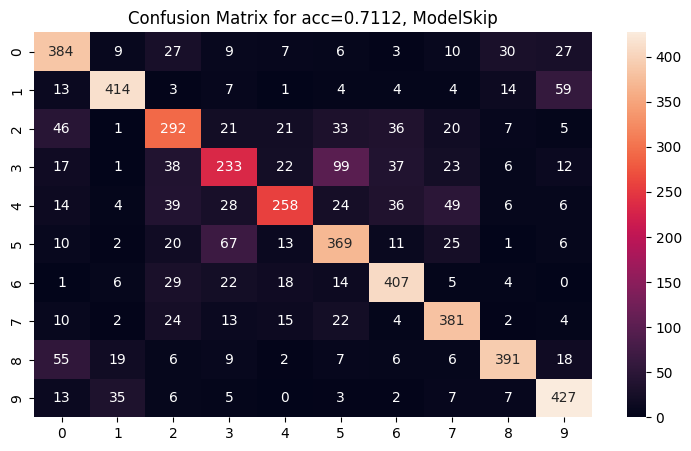

In [ ]:
y_pred, y_true = test_model(test_dl, layer3_model)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}, ModelSkip')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

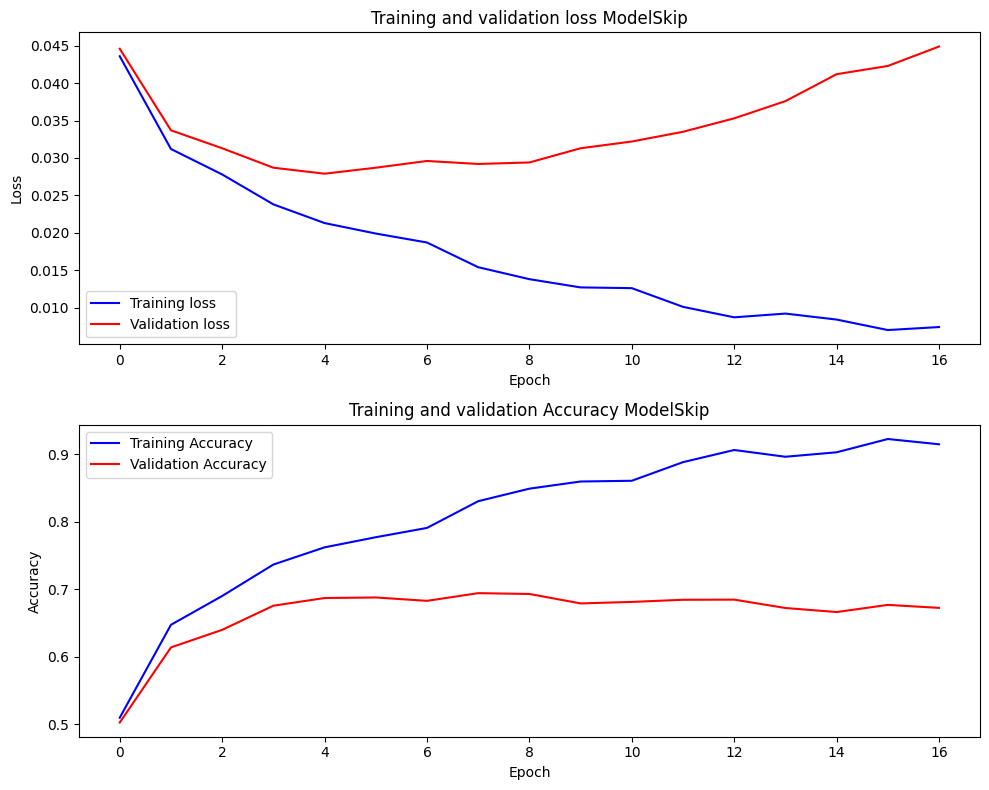

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_1)), loss_train_log_1, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_1)), loss_dev_log_1, 'r', label='Validation loss')
ax1.set_title('Training and validation loss ModelSkip')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_1)), acc_train_log_1, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_1)), acc_dev_log_1, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy ModelSkip')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()